In [7]:
import numpy as np
import models
import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf


# Carregando os dados

In [2]:
us_change = pd.read_csv('us_change.csv')
us_change

,Quarter,Consumption,Income,Production,Savings,Unemployment
0,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
1,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
2,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
3,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
4,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
193,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
194,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
195,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
196,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


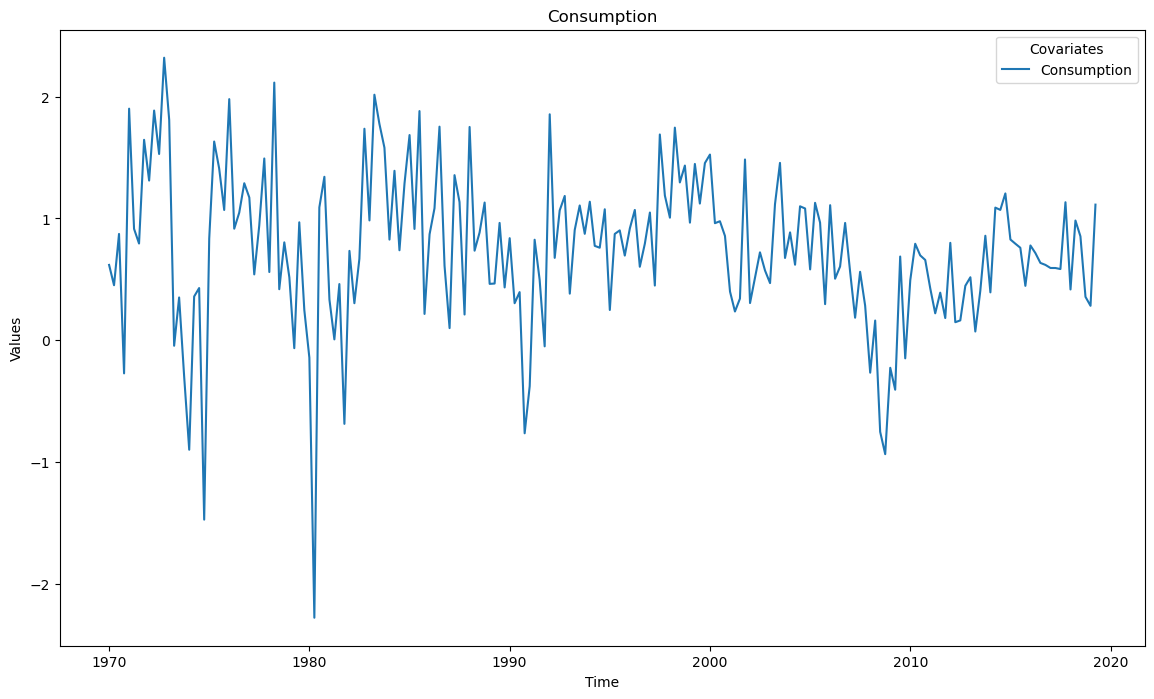

In [3]:
# Convert the 'Quarter' column to datetime format
def parse_quarter(quarter_str):
    year, quarter = quarter_str.split(' ')
    month = (int(quarter[1]) - 1) * 3 + 1
    return pd.Timestamp(f'{year}-{month:02d}-01')

us_change['Quarter'] = us_change['Quarter'].apply(parse_quarter)

# Set the 'Quarter' column as the index
us_change.set_index('Quarter', inplace=True)

# Plot all covariates as time series
plt.figure(figsize=(14, 8))
sns.lineplot(data=us_change['Consumption'], label='Consumption')
plt.title('Consumption')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(title='Covariates')
plt.show()

In [4]:
us_change['Consumption'][:-12]

Quarter
1970-01-01    0.618566
1970-04-01    0.451984
1970-07-01    0.872872
1970-10-01   -0.271848
1971-01-01    1.901345
                ...   
2015-04-01    0.792813
2015-07-01    0.759427
2015-10-01    0.446824
2016-01-01    0.778254
2016-04-01    0.715591
Name: Consumption, Length: 186, dtype: float64

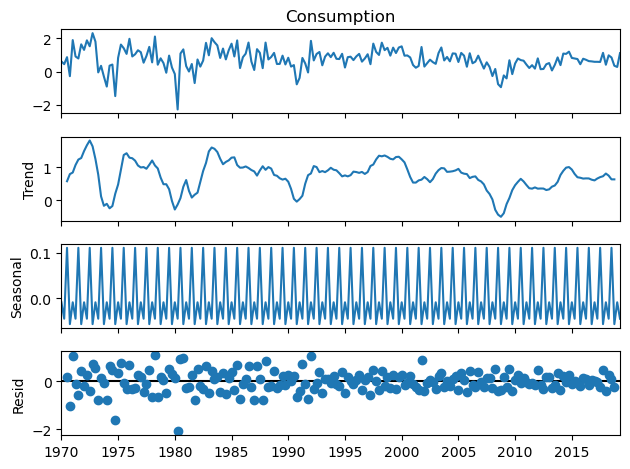

In [5]:
# Decompose the time series
decomposition = seasonal_decompose(us_change['Consumption'], model='additive')
decomposition.plot()
plt.show()

# Modelos de Convolução 1D

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4405 - mae: 0.6166 - val_loss: 0.0205 - val_mae: 0.1156
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0439 - mae: 0.1681 - val_loss: 0.0346 - val_mae: 0.1479
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0307 - mae: 0.1323 - val_loss: 0.0190 - val_mae: 0.1079
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0199 - mae: 0.1101 - val_loss: 0.0171 - val_mae: 0.1022
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0199 - mae: 0.1080 - val_loss: 0.0179 - val_mae: 0.1018
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0202 - mae: 0.1011 - val_loss: 0.0165 - val_mae: 0.0995
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0211 - mae: 0.1079 - val_loss: 0.0165 - val_mae: 0.0987
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0226 - mae: 0.1094 - val_loss: 0.0166 - val_mae: 0.0986
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0215 - mae:

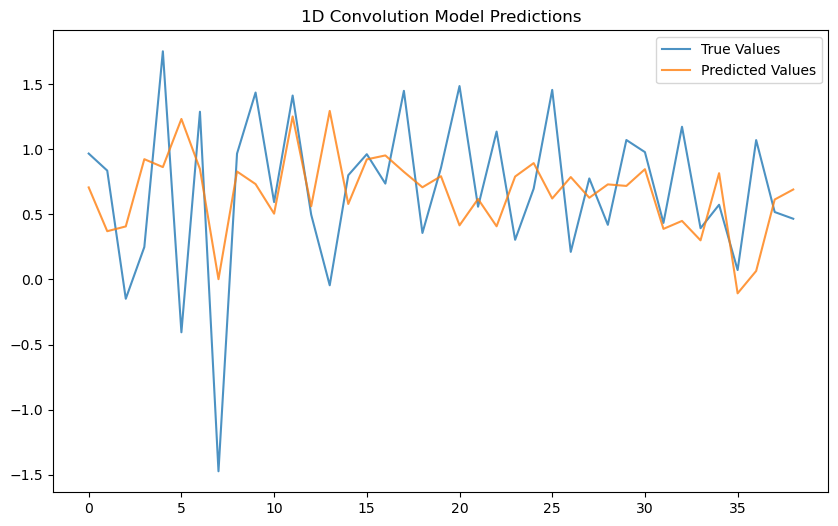

In [9]:
# Selecionar variáveis independentes (X) e dependente (y)
X = us_change[['Income', 'Savings', 'Unemployment', 'Production']]
y = us_change['Consumption']

# Normalizar os dados
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Criar janelas de tempo
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

window_size = 4  # Usar 4 trimestres como janela
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Construir o modelo de convolução 1D
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, X.shape[1])),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Avaliar o modelo
loss, mae = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, MAE: {mae}")

# Fazer previsões
y_pred = model.predict(X_test)

# Reverter a normalização
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

# Plotar resultados
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='True Values', alpha=0.8)
plt.plot(y_pred_inv, label='Predicted Values', alpha=0.8)
plt.title('1D Convolution Model Predictions')
plt.legend()
plt.show()

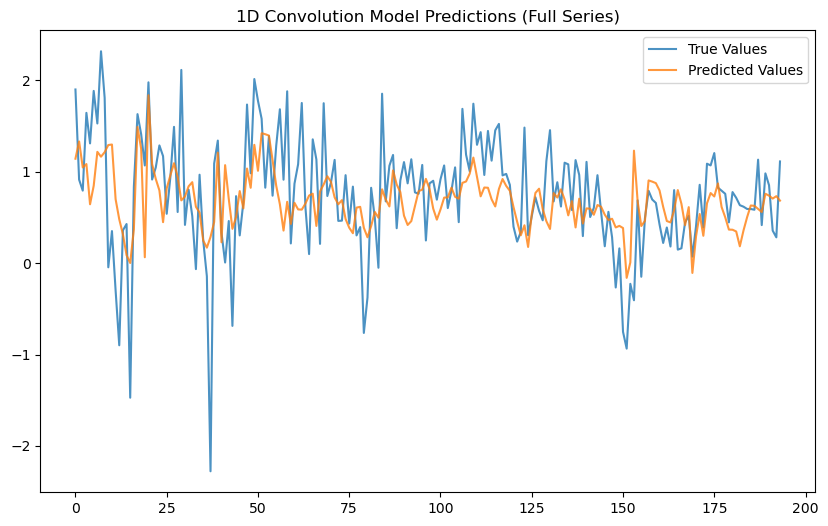

In [11]:
def predict_full_series(model, X_scaled, y_scaled, window_size, scaler_y):
    predictions = []
    input_seq = X_scaled[:window_size]  # Começar com os primeiros valores da série

    for i in range(len(X_scaled) - window_size):
        input_seq_reshaped = input_seq.reshape(1, window_size, -1)
        predicted = model.predict(input_seq_reshaped, verbose=0)
        predictions.append(predicted[0, 0])

        # Atualizar a sequência de entrada
        next_input = X_scaled[window_size + i]
        input_seq = np.vstack([input_seq[1:], next_input])

    predictions = np.array(predictions).reshape(-1, 1)
    return scaler_y.inverse_transform(predictions)

full_predictions = predict_full_series(model, X_scaled, y_scaled, window_size, scaler_y)

# Reverter a normalização dos valores reais
y_true = scaler_y.inverse_transform(y_scaled[window_size:])

# Plotar resultados
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='True Values', alpha=0.8)
plt.plot(full_predictions, label='Predicted Values', alpha=0.8)
plt.title('1D Convolution Model Predictions (Full Series)')
plt.legend()
plt.show()

In [12]:
# Calcular métricas para a série de teste
consumption_test = y_true[-len(X_test):]
predictions_test = full_predictions[-len(X_test):]

results = {
    '1D Convolution Model': {
        'MAE': metrics.mae(consumption_test, predictions_test),
        'MSE': metrics.mse(consumption_test, predictions_test),
        'RMSE': metrics.rmse(consumption_test, predictions_test),
        'MAPE': metrics.mape(consumption_test, predictions_test),
        'SMAPE': metrics.smape(consumption_test, predictions_test),
        'R2': metrics.r2(consumption_test, predictions_test),
        'MASE': metrics.mase(consumption_test, predictions_test, scaler_y.inverse_transform(y_scaled[:len(X_train)])),
        'AIC': metrics.aic(consumption_test, predictions_test, 2),
        'BIC': metrics.bic(consumption_test, predictions_test, 2)
    }
}

# Converter resultados para DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

                            AIC        BIC       MAE       MAPE     MASE  \
1D Convolution Model -87.478724 -84.151601  0.258657  73.346812  0.41972   

                           MSE        R2      RMSE      SMAPE  
1D Convolution Model  0.095789  0.034267  0.309498  52.245294  


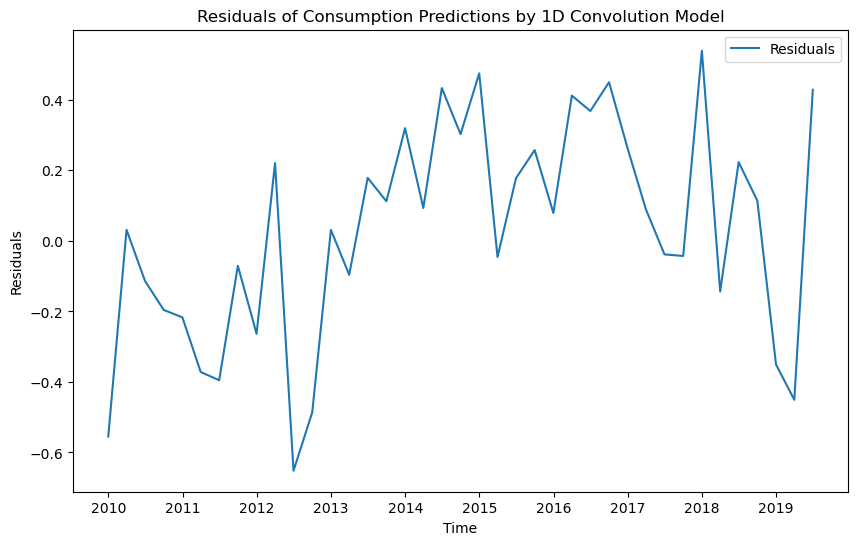

In [13]:
# Calcular os resíduos para cada modelo
residuals = {}
for model in ["1D Convolution Model"]:
    y_pred = predictions_test.flatten()
    y_true = consumption_test.flatten()
    residuals[model] = y_true - y_pred

# Plotar os resíduos
plt.figure(figsize=(10, 6))
residual_series = pd.Series(residuals["1D Convolution Model"], 
                            index=pd.date_range(start=us_change.index[len(us_change)-len(consumption_test)], 
                                                periods=len(consumption_test), freq='Q'))
sns.lineplot(data=residual_series, label='Residuals')
plt.title('Residuals of Consumption Predictions by 1D Convolution Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

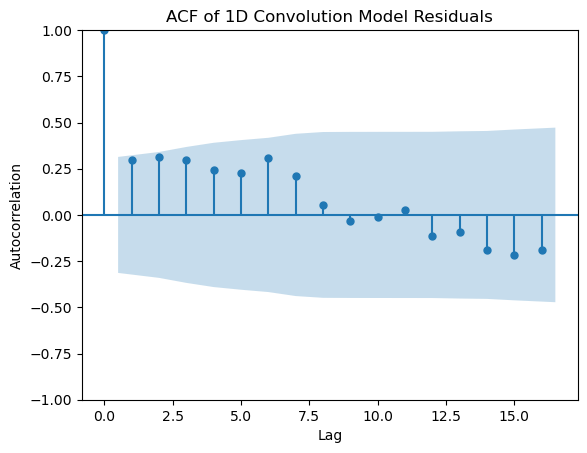

In [14]:
for residual in residuals:
    plot_acf(residuals[residual])
    plt.title(f'ACF of {residual} Residuals')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

In [16]:
from statsmodels.stats.diagnostic import acorr_ljungbox
resid = residuals["1D Convolution Model"]
ljung_box_results = acorr_ljungbox(resid, lags=range(1, 16), return_df=True)
ljung_box_results

,lb_stat,lb_pvalue
1,3.753410,0.052700
2,7.975844,0.018538
3,11.844237,0.007936
4,14.500959,0.005856
5,16.959701,0.004577
6,21.520757,0.001478
7,23.684552,0.001294
8,23.846787,0.002431
9,23.901841,0.004459
10,23.909046,0.007846
